# ET MODIS - análisis
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __1/1/2021__ <br>

__Introducción__<br>
Datos de MODIS sobre cobertura de nieve en la cuenca del Deva. 
1. Se cargan los datos originales (8 días) y se agregan a diversas frecuencias temporales (mensual y anual). Los datos se muestran en mapas y series.
2. Introducción al análisis de EOFs sobre los datos anteriores.

__Cosas que arreglar__ <br>
Cómo leer atributos del archivo _hdf_ de MODIS.

***

__Índice__ <br>
__[1 Datos](#1-Datos)__<br>
[1.1 Cartografía](#1.1-Cartografía)<br>
[1.2 MODIS](#1.2-MODIS)<br>

__[2 Mapas](#2-Mapas)__<br>
[2.1 Media](#2.1-Media)<br>
[2.2 Un día concreto](#2.2-Un-día-concreto)<br>
[2.3 Vídeo](#2.3-Vídeo)<br>

__[3 EOF](#3-EOF)__<br>

In [1]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from calendar import monthrange
import time
import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.animation as animation
from IPython.display import HTML
from pyproj import Proj, transform, CRS
#os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
import copy

In [4]:
os.chdir(rutaBase + '../../../MODIS/py/')
from funciones_EOF import *
from funciones_MODIS import *
os.chdir(rutaBase)

In [5]:
os.chdir(rutaBase + '../../py')
#from class_MODIS import *
from funciones_raster import *

## 1 Datos
### 1.1 Cartografía

In [6]:
# ruta cartografía
#rutaGIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/GIS/'
rutaGIS = os.path.join(rutaBase, '../../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

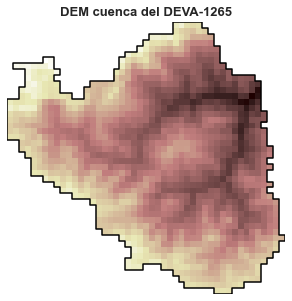

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

cuenca.boundary.plot(ax=ax, edgecolor='k')
ax.imshow(DEM.data, cmap='pink', extent=DEM.extent)

ax.set_title('DEM cuenca del DEVA-1265', fontsize=13, fontweight='bold')
ax.set_aspect('equal')
ax.axis('off');

### 1.2 MODIS

In [8]:
var = 'ET_500m'

In [9]:
ET = {}

for sat in ['Aqua', 'Terra']:
    # Cargar netCDF con los datos climáticos
    rutaExport = os.path.join(rutaBase, '../data/')
    filename = '{0}_{1}_Deva_rellenado.nc'.format(sat, var)

    # importar datos
    ET[sat] = netCDF2MODIS(rutaExport + filename, label='ET')

## 2 Mapas

In [10]:
n_colors = 14
summer_r = cm.get_cmap('summer_r', n_colors)
colors = summer_r(np.linspace(0, 1, n_colors))
cmap_ET = ListedColormap(colors)
boundaries = np.linspace(0, 70, num=n_colors+1, endpoint=True)
norm = BoundaryNorm(boundaries, cmap_ET.N, clip=True)
#snow_patch = mpatches.Patch(color=cmap_snow.colors[1], label='snow')

### 2.1 Media

<ipython-input-11-42de0ba61792>:6: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(ET[sat].data, axis=0), extent=ET[sat].extent(), cmap=cmap_ET,
<ipython-input-11-42de0ba61792>:6: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(ET[sat].data, axis=0), extent=ET[sat].extent(), cmap=cmap_ET,


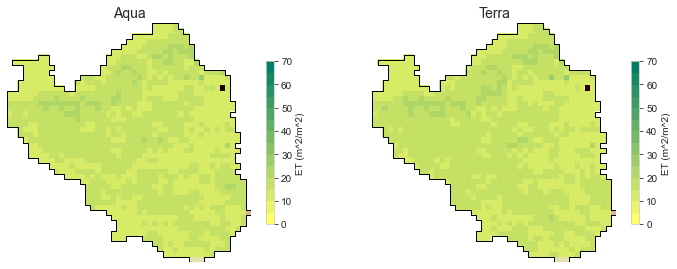

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

for ax, sat in zip(axes, ET):
    
    ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    im = ax.imshow(np.nanmean(ET[sat].data, axis=0), extent=ET[sat].extent(), cmap=cmap_ET,
                   norm=norm, alpha=1)
    cb = plt.colorbar(im, ax=ax, shrink=.5)
    cb.set_label('{0} ({1})'.format(ET[sat].label, ET[sat].units))
    #ET[sat].plot(cmap='summer', ax=ax, alpha=.5)
    cuenca.boundary.plot(color='k', lw=1, ax=ax)
    
    ax.set_title(sat, fontsize=14)
    ax.set_aspect('equal')
    ax.axis('off')

### 2.2 Un día concreto

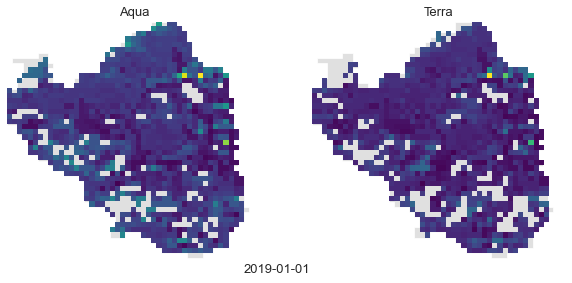

In [12]:
t = datetime(2019, 1, 1).date()

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.text(.5, .15, t, fontsize=13, horizontalalignment='center')

for ax, sat in zip(axes, ET):
    ET[sat].plot(t, ax=ax)
    cuenca.plot(color='lightgray', alpha=.7, ax=ax, zorder=0)
    ax.set_title(sat, fontsize=13);

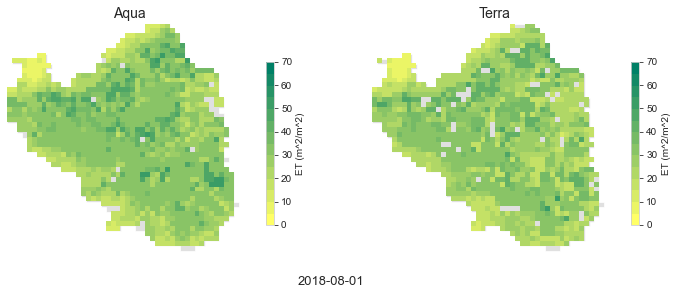

In [13]:
time = datetime(2018, 8, 1)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
fig.text(.5, .175, time.date(), fontsize=13, horizontalalignment='center')

for ax, sat in zip(axes, ET):
    
    # modelo digital del terreno
    #ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    
    # mapa
    if isinstance(time, datetime):
        t = np.where(ET[sat].times >= time.date())[0][0]
    elif isinstance(time, int):
        t = time
    im = ax.imshow(ET[sat].data[t,:,:], extent=ET[sat].extent(), cmap=cmap_ET,
                   norm=norm, alpha=1)
    cb = plt.colorbar(im, ax=ax, shrink=.5)
    cb.set_label('{0} ({1})'.format(ET[sat].label, ET[sat].units))
    
    # polígono de la cuenca
    cuenca.plot(color='lightgray', alpha=.7, ax=ax, zorder=0)
    
    ax.set_title(sat, fontsize=14)
    ax.set_aspect('equal')
    ax.axis('off')

### 2.3 Vídeo

In [ ]:
cellsize = 465

In [ ]:
# definir límites del mapa
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= cellsize * 2
ymin -= cellsize * 2
xmax += cellsize * 2
ymax += cellsize * 2
extent = [xmin, xmax, ymin, ymax]

Hay que recortar los datos de Terra para que coincidan con la duración de los datos de Aqua, es decir, que ambos empiecen el 7 de abril de 2002 (inicio de los datos de Aqua).

In [ ]:
# paso temporal al que corresponde al 7 de abril de 2002
t = np.where(ET['Terra'].times >= ET['Aqua'].times.min())[0][0]

# copia de los datos con fechas coincidentes
ET_ = copy.deepcopy(ET)
terra = ET['Terra']
ET_['Terra'] = raster3D(terra.data[t:,:,:], terra.X, terra.Y, terra.times[t:], units=terra.units, variable=terra.variable, 
                        label=terra.label, crs=terra.crs)

In [ ]:
# comprobar que los datos de los dos satélites tienen la misma dimensión
ET_['Terra'].data.shape, ET_['Aqua'].data.shape

In [ ]:
rutaOut = os.path.join(rutaBase, '../output/')
if os.path.exists(rutaOut) is False:
    os.makedirs(rutaOut)
mp4File = rutaOut + 'ET_Terra_Aqua.mp4'
video2(ET_['Aqua'], ET_['Terra'], cuenca, cmap_ET, norm, DEM, fps=4, dpi=150, ax=axes[0], figsize=(12, 6), extent=extent,
       labels=['Aqua', 'Terra'], export=mp4File)

## 2.2 Series
### 8 días

C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:543: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)
C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:543: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)


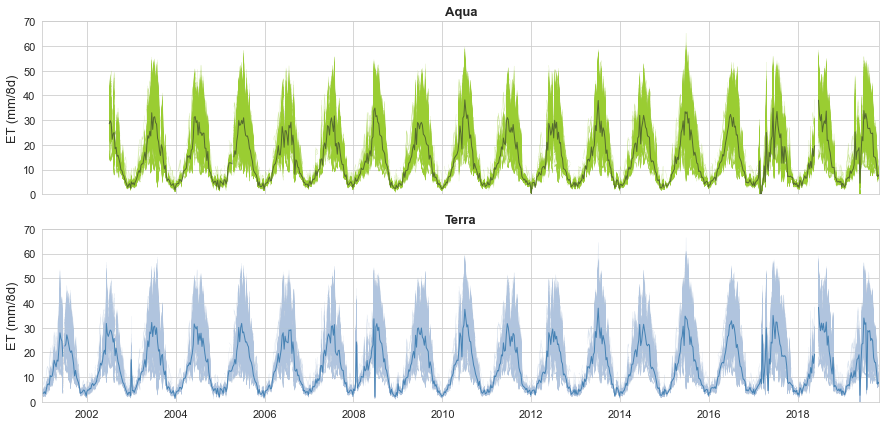

In [14]:
plotMODISseries(ET, r=5, ymin=False, alpha=.5, ylabel='ET (mm/8d)')

### Mensual

C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:767: RuntimeWarning: Mean of empty slice
  meanM[m,:,:] = np.nanmean(modis.data[ks,:,:], axis=0)


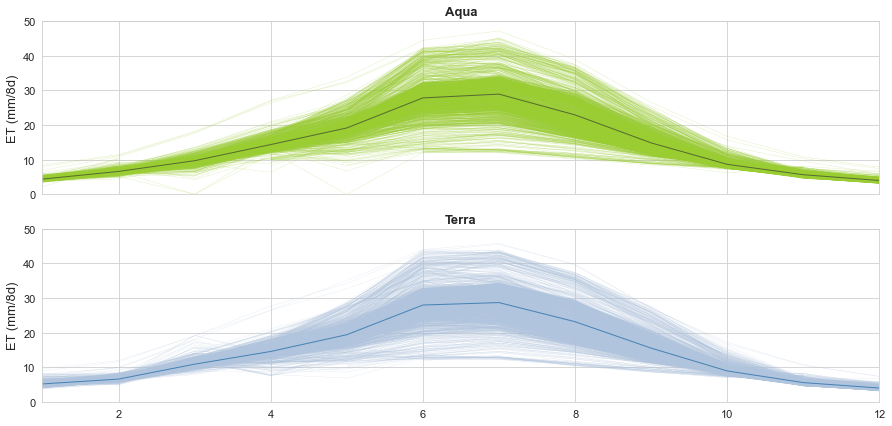

In [15]:
# media mensual
ETmm = {sat: mediaMensual(ET[sat]) for sat in ET}

# gráfico de la media mensual
plotMODISseries(ETmm, r=5, ymin=False, alpha=.5, ylabel='ET (mm/8d)')

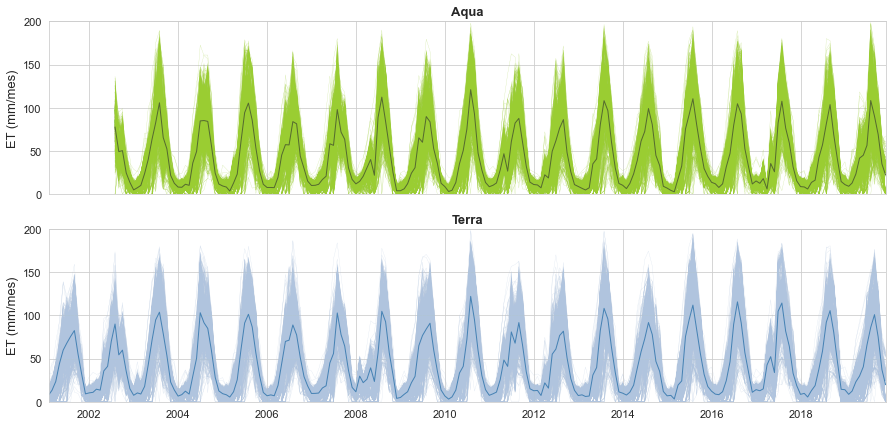

In [16]:
# serie mensual
ETsm = {sat: serieMensual(ET[sat], agg='sum') for sat in ET}

# gráfico de la serie mensual
plotMODISseries(ETsm, r=5, ymin=False, alpha=.5, ylabel='ET (mm/mes)')

### Anual

C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:874: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data[maskT,:,:], axis=0)
C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:543: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)
C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_MODIS.py:543: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)


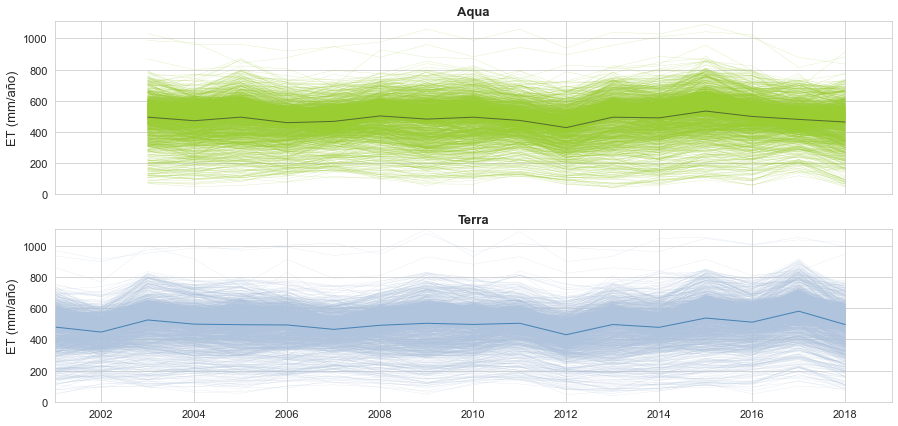

In [17]:
# serie anual
ETsa = {sat: serieAnual(ET[sat], agg='sum') for sat in ET}

# gráfico de la serie anual
plotMODISseries(ETsa, r=5, ymin=False, alpha=.5, ylabel='ET (mm/año)')

## 3 EOF
#### Terra

C:\Users\jcr693\Documents\GitHub\MODIS\py\funciones_EOF.py:112: UserWarning: No contour levels were found within the data range.
  ax.contour(eofmap[i,:,:], np.linspace(mapmin, mapmax, 5), colors='k', linewidths=.5)
<ipython-input-18-1a4da7be8fdc>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(rutaExport + 'ET eofs-Terra anual.png', dpi=300, tight_layout=True)


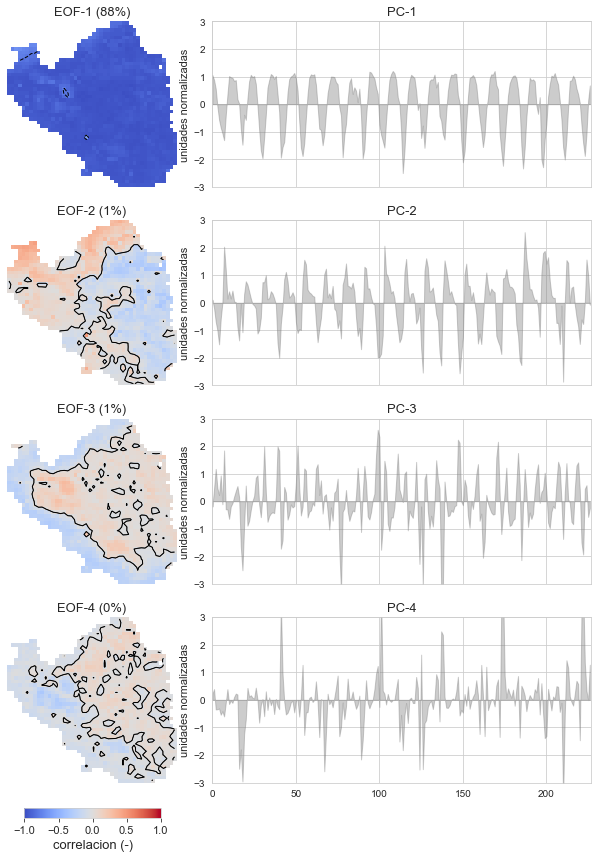

In [18]:
eofMODIS(ETsm['Terra'], nmodes=4, plot='corr')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'ET eofs-Terra anual.png', dpi=300, tight_layout=True)

#### Aqua

In [20]:
eofMODIS(ETsa['Aqua'], nmodes=4, plot='eofs')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
var = eofMODIS.explainedVariance
plt.savefig(rutaExport + 'ET eofs-Terra anual.png', dpi=300)

ValueError: all input data is missing